In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/"My Drive"/kaggle/moa/lish-moa.zip /content/

In [3]:
!unzip lish-moa.zip

Archive:  lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  


In [4]:
!pip install pip install iterative-stratification

In [42]:
from sklearn.preprocessing import MinMaxScaler
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler


import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import random 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm, tnrange
import os
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

plt.rcParams['figure.figsize'] = 15, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=1903):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print("seed kar diya")


In [43]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device


'cuda'

In [78]:
train_features = pd.read_csv('train_features.csv')
train_targets = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [79]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [80]:
# top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
#         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
#         32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
#         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
#         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
#         74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
#         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
#        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
#        115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
#        129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
#        144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
#        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
#        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
#        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
#        198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
#        213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
#        227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
#        240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
#        254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
#        267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
#        281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
#        295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
#        310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
#        324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
#        337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
#        350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
#        363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
#        378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
#        392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
#        405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
#        419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
#        432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
#        447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
#        463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
#        476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
#        490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
#        506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
#        522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
#        538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
#        552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
#        571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
#        586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
#        600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
#        618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
#        631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
#        645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
#        660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
#        673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
#        686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
#        701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
#        718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
#        733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
#        748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
#        762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
#        775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
#        789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
#        804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
#        821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
#        837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
#        854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
#        870, 871, 872, 873, 874]

# all_columns = train.columns
# train=train[all_columns[top_features]]
# test = test[all_columns[top_features]]

In [81]:
train.shape, test.shape

((21948, 876), (3982, 876))

In [82]:
train = train.values[:,1:].astype(np.float)
target = target.values
test = test.values[:,1:].astype(np.float)

In [84]:
test[0]

array([ 0.000e+00,  2.400e+01,  0.000e+00, -5.458e-01,  1.306e-01,
       -5.135e-01,  4.408e-01,  1.550e+00, -1.644e-01, -2.140e-01,
        2.221e-01, -3.260e-01,  1.939e+00, -2.305e-01, -3.670e-01,
        1.304e+00,  1.461e+00,  4.300e-03,  6.816e-01, -2.304e-01,
       -6.350e-02, -2.030e-01, -6.821e-01, -6.242e-01,  1.297e-01,
       -3.380e-02,  3.372e-01,  2.254e-01,  4.795e-01,  7.642e-01,
        6.638e-01, -2.480e-01, -1.183e-01, -4.847e-01, -1.790e-02,
       -8.204e-01, -5.296e-01, -1.507e+00, -1.440e-02,  4.448e-01,
        5.753e-01, -2.993e-01, -9.532e-01, -1.443e-01, -1.088e+00,
        2.080e-01,  5.670e-01,  1.119e+00, -4.550e-02,  2.789e-01,
       -1.023e+00, -6.231e-01, -6.682e-01, -7.180e-02, -1.524e+00,
        9.117e-01,  6.883e-01, -1.073e-01, -1.134e-01,  4.536e-01,
        5.514e+00,  3.271e-01,  1.388e-01, -2.321e-01,  1.517e+00,
        5.460e-02,  9.043e-01, -3.088e-01,  1.536e+00,  1.511e-01,
       -3.711e-01, -1.950e-02, -4.992e-01,  1.208e+00, -3.614e

In [85]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target


In [86]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [99]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(875)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(875, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 2048))
        
        self.batch_norm3 = nn.BatchNorm1d(2048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(2048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [109]:

def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, test = test,  fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):
     
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            
            scheduler.step(1.)   ## lr decay caller 

            learning_rates.append(get_lr(optimizer))
            
        if validate == True:
            with torch.no_grad():
                model.eval()
                val_losses_temp = []
                for x_val, y_val in val_loader:
                    yhat =model(x_val.to(device))  # pred 
                    val_loss = criterion(yhat.to(device), y_val.to(device))
                    val_losses_temp.append(val_loss.item())  ## metrics 
                val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 

        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()

            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    test_dataset = TrainDataset(test, target, noise = False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

    model = Model()
    model.load_state_dict(torch.load(name))
    model.to(device)
    preds = inference_fn(model, test_loader, device)

    return val_losses, name, preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs, labels = data

        with torch.no_grad():
            outputs = model(inputs.to(device))
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [110]:
def train_model_and_return_test_preds(num_folds, num_epochs, lr, batch_size, decay_factor, decay_patience, train, target, test):

    mskf = MultilabelStratifiedKFold(n_splits= num_folds, shuffle=True, random_state=0)

    fold_val_losses = list()
    
    predictions = np.zeros((len(test), 206))

    for k , (train_idx,valid_idx) in enumerate(mskf.split(train,target)):

        x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx,:],target[valid_idx,:]

        input_size = x_train.shape[1]
        output_size = target.shape[1]
        
        
        train_dataset = TrainDataset(x_train, y_train, noise = False)
        valid_dataset = TrainDataset(x_valid, y_valid, noise = False)
        
        train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True)

        val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = True)
        
        model = Model()


        model = model.to(device)

        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-5)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                        mode='min', 
                                                        factor= decay_factor, ## wooo hoo
                                                        patience=decay_patience, ## was 3 for 158 
                                                        eps=1e-4, 
                                                        verbose=True)
        criterion = nn.BCEWithLogitsLoss()
        
        if k > 1:
            print(CRED ,"fold ", str(k+1), "  :: mean loss on all folds: ", np.array([min(l) for l in fold_val_losses]).mean(), CEND)

        val_losses, filename , preds = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1, test = test)
        fold_val_losses.append(val_losses)

        predictions += preds / num_folds
        
    return predictions, fold_val_losses


In [115]:
predictions = np.zeros((len(test), 206))
seeds =  [1903, 1881]

for seed in seeds:
    seed_everything(seed = seed)
    preds, fold_val_losses = train_model_and_return_test_preds(num_folds = 10, 
                                    num_epochs = 45, 
                                    lr = 0.004299882049752947, 
                                    batch_size = 128,
                                    decay_factor = 0.1, 
                                    decay_patience = 8, 
                                    train = train, 
                                    target = target, 
                                    test = test
                                    )
    predictions += preds / len(seeds)


seed kar diya
epoch  1  out of  45      > Val loss decreased from: 1000000  to  0.020441744476556778    >saving model as:  ./model_1.pth
epoch  2  out of  45      > Val loss decreased from: 0.020441744476556778  to  0.018870705738663673    >saving model as:  ./model_1.pth
epoch  3  out of  45      > Val loss decreased from: 0.018870705738663673  to  0.0180932879447937    >saving model as:  ./model_1.pth
epoch  4  out of  45      >showing no improvements, best loss yet: 0.0180932879447937
epoch  5  out of  45      > Val loss decreased from: 0.0180932879447937  to  0.01717430166900158    >saving model as:  ./model_1.pth
epoch  6  out of  45      > Val loss decreased from: 0.01717430166900158  to  0.017045237123966217    >saving model as:  ./model_1.pth
epoch  7  out of  45      > Val loss decreased from: 0.017045237123966217  to  0.016998153179883957    >saving model as:  ./model_1.pth
epoch  8  out of  45      >showing no improvements, best loss yet: 0.016998153179883957
epoch  9  out o

In [116]:
predictions[0][:5]

array([0.00076782, 0.00084333, 0.00230426, 0.01547371, 0.02112664])

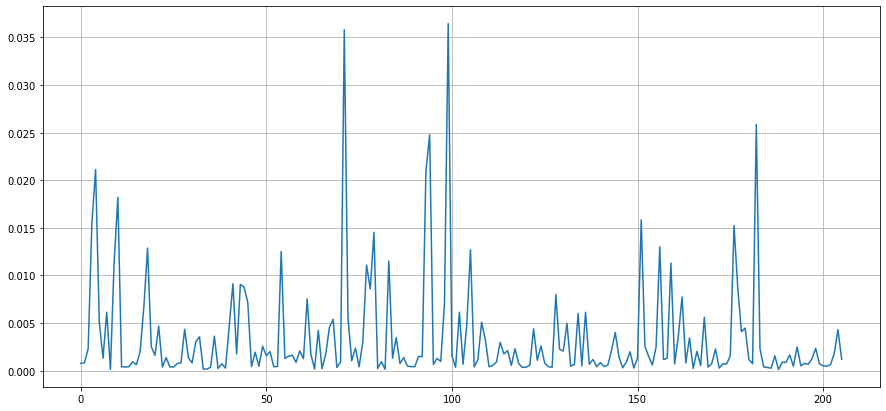

In [117]:
plt.plot(predictions[0])
plt.grid()

0.015713307354599238

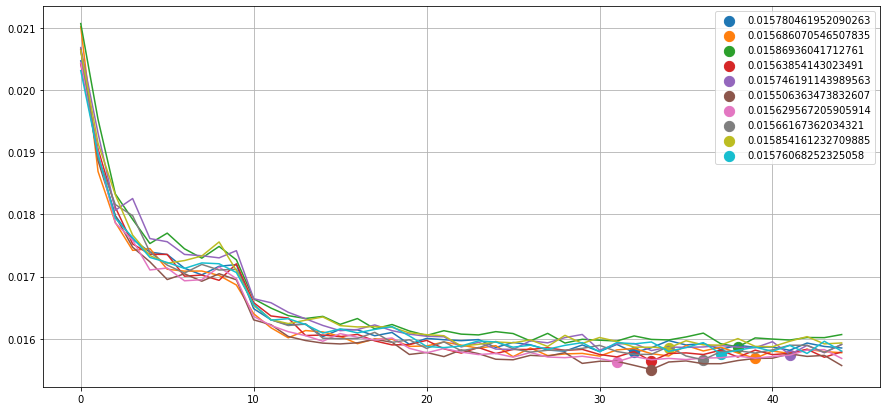

In [118]:
for l in fold_val_losses:
    plt.plot(l)
    plt.scatter([l.index(min(l))], [min(l)],s = 105, label = str(min(l)))
plt.grid()
plt.legend()

minimas = []
for i in fold_val_losses:
    minimas.append(min(i))

np.array(minimas).mean()
## best yet


In [119]:
predictions

array([[0.00076782, 0.00084333, 0.00230426, ..., 0.00179961, 0.0043172 ,
        0.00120759],
       [0.00027013, 0.0009506 , 0.00181589, ..., 0.00081296, 0.00128002,
        0.00342525],
       [0.00047722, 0.0003703 , 0.00246729, ..., 0.00453238, 0.0004479 ,
        0.00236072],
       ...,
       [0.00064053, 0.00048456, 0.0007446 , ..., 0.00099891, 0.00041231,
        0.00102656],
       [0.0015757 , 0.00096861, 0.0011021 , ..., 0.00140459, 0.00047403,
        0.00288218],
       [0.00042428, 0.00065828, 0.0010458 , ..., 0.00172391, 0.00028746,
        0.00103138]])

In [120]:
submission = pd.read_csv('sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

import csv 
a = predictions  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

final_sub = pd.read_csv('./submission_cp.csv', header = None)

final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]

good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]

In [121]:
targets = [col for col in final_sub.columns]
final_sub.loc[test_features['cp_type']=='ctl_vehicle', targets[1:]] = 0
final_sub.to_csv('submission.csv', index=False)

In [122]:
final_sub


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000768,0.000843,0.002304,0.015474,0.021127,0.005082,0.001310,0.006143,0.000151,0.011404,0.018193,0.000430,0.000389,0.000423,0.000943,0.000645,0.002011,0.006703,0.012887,0.002535,0.001606,0.004682,0.000376,0.001380,0.000408,0.000387,0.000758,0.000840,0.004359,0.001376,0.000824,0.003051,0.003558,0.000175,0.000171,0.000372,0.003620,0.000236,0.000730,...,0.002039,0.000552,0.005611,0.000386,0.000742,0.002280,0.000285,0.000735,0.000708,0.001586,0.015238,0.008764,0.004104,0.004475,0.001184,0.000741,0.025843,0.002308,0.000390,0.000342,0.000270,0.001565,0.000129,0.000908,0.000868,0.001666,0.000472,0.002499,0.000518,0.000774,0.000686,0.001246,0.002352,0.000741,0.000510,0.000480,0.000642,0.001800,0.004317,0.001208
1,id_001897cda,0.000270,0.000951,0.001816,0.003256,0.002077,0.001819,0.004854,0.007774,0.004767,0.011620,0.011719,0.002393,0.000390,0.010478,0.000600,0.000558,0.001011,0.002520,0.002556,0.003055,0.003893,0.001395,0.000409,0.000919,0.000564,0.001335,0.000756,0.000507,0.001973,0.000949,0.000925,0.002553,0.000962,0.001554,0.000263,0.000306,0.003847,0.003263,0.004317,...,0.001223,0.001019,0.000598,0.000469,0.001607,0.002737,0.001342,0.013964,0.001397,0.003814,0.008534,0.003807,0.000681,0.000713,0.001437,0.003578,0.006877,0.000697,0.021829,0.000418,0.002158,0.004049,0.001189,0.000605,0.000331,0.000846,0.000867,0.001927,0.006306,0.002195,0.000781,0.000813,0.005292,0.000400,0.011111,0.000414,0.009214,0.000813,0.001280,0.003425
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_0027

In [58]:
final_sub


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000712,0.000845,0.001926,0.013079,0.020879,0.004594,0.001164,0.005800,0.000124,0.010284,0.017457,0.000827,0.000348,0.000436,0.000797,0.000590,0.001999,0.005281,0.010209,0.002171,0.001449,0.003943,0.000348,0.001156,0.000489,0.000335,0.000743,0.000806,0.004699,0.001636,0.000882,0.002781,0.002880,0.000161,0.000157,0.000420,0.003385,0.000301,0.000710,...,0.002455,0.000561,0.004390,0.000402,0.000623,0.001731,0.000260,0.000980,0.000616,0.001513,0.011037,0.009106,0.003734,0.003816,0.001158,0.000745,0.022784,0.002327,0.000366,0.000355,0.000336,0.001613,0.000134,0.000879,0.001009,0.001669,0.000450,0.002375,0.000652,0.000763,0.000548,0.001097,0.002058,0.000763,0.000537,0.000416,0.000801,0.001408,0.003952,0.000998
1,id_001897cda,0.000257,0.000832,0.001988,0.003099,0.001941,0.001825,0.004720,0.008049,0.006754,0.015794,0.011369,0.002299,0.000335,0.010562,0.000525,0.000468,0.000760,0.002418,0.002272,0.003526,0.002915,0.001272,0.000301,0.000711,0.000454,0.001307,0.000689,0.000355,0.001688,0.001106,0.000643,0.001936,0.000829,0.001365,0.000235,0.000258,0.002943,0.003547,0.006169,...,0.000893,0.000875,0.000463,0.000427,0.001283,0.002530,0.001457,0.019115,0.001026,0.002941,0.008045,0.002810,0.000495,0.000721,0.001148,0.003450,0.006536,0.000577,0.020774,0.000363,0.001991,0.003868,0.001541,0.000624,0.000280,0.000796,0.000705,0.001918,0.005143,0.002064,0.000890,0.000744,0.005034,0.000305,0.011475,0.000322,0.010895,0.000808,0.001495,0.003812
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_0027